# CNN 구현

## 실습 개요

1) **실습 목적**

이번 실습은 이론으로 배웠던 PyTorch를 이용하여 대표적인 CNN 모델을 학습하고 평가하는 과정까지 전 과정을 직접 구현해봅니다.



2) **수강 목표**

- PyTorch를 사용해 대표적인 CNN 모델을 구현할 수 있다.
- CNN 모델의 동작원리를 이해하고 구현할 수 있다.

### 실습 목차
* 1. 기본적인 CNN 모델 구축하기
  * 1-1. PyTorch에서 convolution 연산
  * 1-2. Custom CNN 모델 구축하기
  * 1-3. 학습과 평가하기

* 2. VGG 모델 구축하기
  * 2-1. VGG 모델 구축하기
  * 2-2. 학습과 평가하기

* 3. GoogleNet 모델 구축하기
  * 3-1. GoogleNet 모델 구축하기
  * 3-2. 학습과 평가하기
  
* 4. ResNet 모델 구축하기
  * 4-1. ResNet 모델 구축하기
  * 4-2. 학습과 평가하기



### 환경 설정

- 패키지 설치 및 임포트

In [ ]:
!pip install scikit-learn==1.3.0 -q
!pip install torch==2.0.1 -q
!pip install torchvision==0.15.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 74.3 MB/s eta 0:00:00


In [1]:
import numpy as np # 기본적인 연산을 위한 라이브러리
import matplotlib.pyplot as plt # 그림이나 그래프를 그리기 위한 라이브러리
from tqdm.notebook import tqdm # 상태 바를 나타내기 위한 라이브러리
import math # 수학 계산을 위한 라이브러

import torch # PyTorch 라이브러리
import torch.nn as nn # 모델 구성을 위한 라이브러리
import torch.optim as optim # optimizer 설정을 위한 라이브러리
from torch.utils.data import Dataset, DataLoader # 데이터셋 설정을 위한 라이브러리
import torch.nn.functional as F # torch에서 수학적인 function을 쉽게 불러오기 위한 라이브러리

import torchvision.transforms as T # 이미지의 다양성을 주기 위한 라이브러리
import torchvision # torch에서 이미지를 처리하기 위한 라이브러
import torchvision.utils as vutils # torch로 구성된 이미지를 쉽게 구성하기 위한 라이브러리

from sklearn.metrics import accuracy_score # 정확도 성능지표 측정

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [3]:
# Hyper parameter
patience = 3
verbose = True

device = 'cpu' # gpu 설정 -> m1은 불가능 -> cpu로 설정

###  데이터 셋 개요 </b>

* 데이터 셋: MNIST 데이터베이스(Modified National Institute of Standards and Technology database)
* 데이터 셋 개요: MNIST는 숫자 0부터 9까지의 이미지로 구성된 손글씨 데이터셋입니다. 총 6만 개의 학습 데이터와 1만 개의 숫자 데이터로 이루어져 있으며 [이미지]와 [숫자에 대한 라벨]로 구성됩니다.
* 데이터 셋 저작권: CC BY-SA 3.0
* [MNIST - 위키피디아](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4)



## 1. 기본적인 CNN 모델 구현하기

```
💡 목차 개요: CNN 모델을 직접 구현하고, MNIST 데이터셋으로 학습과 평가하는 과정을 실습합니다.
```

- 1-1. PyTorch에서 Convolution 연산
- 1-2. Custom CNN 모델 구현하기

### 1-1 PyTorch에서 Convoltuion 연산

> `torch.nn.Conv2d` 를 이용하여 Convolution 연산을 할 수 있습니다.


#### 📝 설명: Convoltuion이란?
<img src='https://gaussian37.github.io/assets/img/dl/concept/conv/1.gif'></img>

* Convolution 연산은 이미지 처리에서 중요하고 자주 사용되는 연산 개념입니다.
* Convolution은 두 함수를 합성하는 수학적인 연산으로 한국말로 `합성곱`이라고 불립니다.
* 이미지 처리에선 이미지의 픽셀과 필터를 서로 합성(원소끼리 곱)하는 방식으로 계산됩니다.
* Convolution 연산을 거친 결과값(feature map) 다음과 같은 공식으로 크기를 계산할 수 있습니다.
$$ O = \lfloor \frac{I + 2P - K}{S} \rfloor + 1$$
  * $O$ : output size를 의미합니다.
  * $I$ : Input size를 의미합니다.
  * $P$ : 패딩 사이즈를 의미합니다.
  * $K$ : 필터 사이즈를 의미합니다.
  * $S$ : stride 사이즈를 의미합니다.

📚 참고할만한 자료:
* <a href='https://gaussian37.github.io/dl-concept-covolution_operation/'>
Convolution 설명</a>
<a href='https://github.com/AxelThevenot/GIF_convolutions'>Convolution 사진 출처 (MIT License)</a>

#### 📝 설명: PyTorch에서 Convolution 연산
* PyTroch에선 `torch.nn.Conv2d`로 convolution 연산을 지원합니다.
* `torch.nn.Conv2d`의 파라미터는 다음과 같습니다.
  * `in_channels` : input 값의 채널을 의미합니다.
    * ex) input shape : (BATCH_SIZE, 3, 256, 256) => in_channels = 3
  * `out_channels` : convolution 연산을 통해 생성된 아웃풋의 채널을 의미합니다.
    * ex) output shape : (BATCH_SIZE, 64, 256, 256) => out_channels = 64
  * `kernel_size` : 필터의 크기를 의미합니다. (필터 사이즈 = kernel_size x kernel_size)
  * `stride` : 필터의 이동 간격을 의미합니다.
  * `padding` :  입력 데이터 주변에 추가되는 값(padding)의 크기를 의미합니다.



📚 참고할만한 자료:
* <a href='https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html'>
PyTorch Conv2d 공식 사이트</a>

In [7]:
# 샘플 이미지 구조의 텐서 생성
BATCH_SIZE = 16
# (채널, 높이, 너비) -> tensorflow의 순서와 다르다.
# batchsize는 없어도 괜찮다.
sample = torch.randn(BATCH_SIZE, 3, 224, 224)
conv = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1, padding = 0)
# ((I + 2xP - K )/ S) + 1  = O; ((224 + (2 x 0) - 5) / 1) + 1 = 220
conv(sample).shape

torch.Size([16, 6, 220, 220])

In [8]:
# 이 때, input channel의 수를 꼭 넣고자 하는 이미지의 채널과 맞춰줘야합니다.
BATCH_SIZE = 16
sample = torch.randn(BATCH_SIZE, 3, 224, 224) # 3채널을 가진 이미지
conv = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1, padding = 0) # input image의 채널을 1로 설정
conv(sample).shape # 에러 발생

RuntimeError: Given groups=1, weight of size [6, 1, 5, 5], expected input[16, 3, 224, 224] to have 1 channels, but got 3 channels instead

### 1-2 Custom CNN 모델 구현하기

> convolution layer를 쌓아서 자신만의 CNN 모델을 구현할 수 있습니다.

> MNIST를 분류할 수 있는 CNN 모델을 만들어봅니다.


#### 📝 설명: Pooling Layer란?
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fd5BtYV%2FbtsqZyYY4ot%2FNCwHDkg21KMaAG4mkZtiNK%2Fimg.png'></img>

* Pooling Layer는 convolution 레이어의 출력으로부터 정보를 요약하고, 계산 비용을 줄이며, 불필요한 정보를 제거하여 모델을 더욱 효율적으로 만드는 역할을 합니다.

* Pooling을 하는 방식은 크게 두가지로 Max Pooling 과 Average Pooling이 있습니다.
  * Max Pooling
    * 각 영역에서 가장 큰 값을 선택하여 크기를 줄이는 방식입니다.
    * 특징 맵의 중요한 특징을 강조하고 불필요한 정보를 줄이는데 도움이 됩니다.
    * PyTorch 에선 `torch.nn.MaxPool2d`로 구현 가능합니다.
  * Average Pooling
    * 각 영역의 평균 값을 선택하여 크기를 줄이는 방식입니다.
    * Max Pooling에 비해 많은 정보를 유지하지만, 주요 특징을 강조하는 데는 덜 효과적일 수 있습니다.
    * PyTorch 에선 `torch.nn.AvgPool2d`로 구현 가능합니다.

📚 참고할만한 자료:
* <a href='https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html'>PyTorch MaxPool2d</a>
* <a href='https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html'>PyTorch AvgPool2d</a>
* <a href='https://bigdata-analyst.tistory.com/374'>이미지 출처</a>

In [11]:
# MNIST 분류를 위한 CNN 모델
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_ratio):
        super(CNN, self).__init__()
        self.num_classes = num_classes

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),  # [BATCH_SIZE, 1, 28, 28] -> [BATCH_SIZE, 16, 24, 24]
            nn.ReLU(),  # ReLU 활성화 함수 적용
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), # [BATCH_SIZE, 16, 24, 24] -> [BATCH_SIZE, 32, 20, 20]
            nn.ReLU(),  # ReLU 활성화 함수 적용
            nn.MaxPool2d(kernel_size=2), # [BATCH_SIZE, 32, 20, 20] -> [BATCH_SIZE, 32, 10, 10]
            nn.Dropout(dropout_ratio),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # [BATCH_SIZE, 32, 10, 10] -> [BATCH_SIZE, 64, 6, 6]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 크기를 1/2로 줄입니다. [BATCH_SIZE, 64, 6, 6] -> [BATCH_SIZE, 64, 3, 3]
            nn.Dropout(dropout_ratio),
        )

        # self.flatten = nn.Flatten()
        self.fc_layer = nn.Linear(64*3*3, self.num_classes) # [BATCH_SIZE, 64*3*3] -> [BATCH_SIZE, num_classes]
        self.softmax = nn.LogSoftmax(dim = 1)


    def forward(self,x):
        '''
        Input and Output Summary

        Input :
            x : [batch_size, channel, height, width]
        Output :
            pred : [batch_size, num_classes]
        '''
        out = self.layer(x) # self.layer에 정의한 Sequential의 연산을 차례대로 다 실행합니다. [BATCH_SIZE, 64, 3, 3]
        out = out.view(x.size(0), -1)  # [BATCH_SIZE, 64*3*3] -> view함수를 사용하여 Flatten진행
        pred = self.fc_layer(out) # [BATCH_SIZE, num_classes]
        pred = self.softmax(pred) # [BATCH_SIZE, num_classes]

        return pred

    def weight_initialization(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)


    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [12]:
num_classes = 10
dropout_ratio = 0.5
model = CNN(num_classes = num_classes, dropout_ratio = dropout_ratio).to(device)
model.count_parameters() # 참고로 DNN 구현(2)에 있는 모델은 약 57만개의 파라미터, 반면에 CNN은 layer 가 DNN 보다 하나 더 많음에도 불구하고, 훨씬 적음

70282

### 1-3 학습 및 평가하기

> Custom CNN 모델을 MNIST 데이터셋으로 학습시켜 분류해봅니다.


In [13]:
# 데이터를 불러올 때, 필요한 변환(transform)을 정의합니다.
mnist_transform = T.Compose([
    T.ToTensor(), # 텐서 형식으로 변환
])

In [14]:
# torchvision 라이브러리를 사용하여 MNIST 데이터 셋을 불러옵니다.
download_root = './MNIST_DATASET'

train_dataset = torchvision.datasets.MNIST(download_root, transform=mnist_transform, train=True, download=True) # train dataset 다운로드
test_dataset = torchvision.datasets.MNIST(download_root, transform=mnist_transform, train=False, download=True) # test dataset 다운로드

In [15]:
# 데이터 셋을 학습 데이터 셋과 검증 데이터 셋으로 분리합니다.
total_size = len(train_dataset)
train_num, valid_num = int(total_size * 0.8), int(total_size * 0.2) # 8 : 2 = train : valid
print("Train dataset 개수 : ", train_num)
print("Validation dataset 개수 : ", valid_num)
train_dataset,valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num]) # train - valid set 나누기

Train dataset 개수 :  48000
Validation dataset 개수 :  12000


In [16]:
# 앞서 선언한 Dataset을 인자로 주어 DataLoader를 선언합니다.
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [17]:
# training 코드, evaluation 코드, training_loop 코드
def training(model, dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs):
  model.train()  # 모델을 학습 모드로 설정
  train_loss = 0.0
  train_accuracy = 0

  tbar = tqdm(dataloader)
  for images, labels in tbar:
      images = images.to(device)
      labels = labels.to(device)

      # 순전파
      outputs = model(images)
      loss = criterion(outputs, labels)

      # 역전파 및 가중치 업데이트
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 손실과 정확도 계산
      train_loss += loss.item()
      # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
      _, predicted = torch.max(outputs, 1)
      train_accuracy += (predicted == labels).sum().item()

      # tqdm의 진행바에 표시될 설명 텍스트를 설정
      tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}")

  # 에폭별 학습 결과 출력
  train_loss = train_loss / len(dataloader)
  train_accuracy = train_accuracy / len(train_dataset)

  return model, train_loss, train_accuracy

def evaluation(model, dataloader, val_dataset, criterion, device, epoch, num_epochs):
  model.eval()  # 모델을 평가 모드로 설정
  valid_loss = 0.0
  valid_accuracy = 0

  with torch.no_grad(): # model의 업데이트 막기
      tbar = tqdm(dataloader)
      for images, labels in tbar:
          images = images.to(device)
          labels = labels.to(device)

          # 순전파
          outputs = model(images)
          loss = criterion(outputs, labels)

          # 손실과 정확도 계산
          valid_loss += loss.item()
          # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
          _, predicted = torch.max(outputs, 1)
          valid_accuracy += (predicted == labels).sum().item()

          # tqdm의 진행바에 표시될 설명 텍스트를 설정
          tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}")

  valid_loss = valid_loss / len(dataloader)
  valid_accuracy = valid_accuracy / len(val_dataset)

  return model, valid_loss, valid_accuracy


def training_loop(model, train_dataloader, valid_dataloader, train_dataset, val_dataset, criterion, optimizer, device, num_epochs, patience, model_name):
    best_valid_loss = float('inf')  # 가장 좋은 validation loss를 저장
    early_stop_counter = 0  # 카운터
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, val_dataset, criterion, device, epoch, num_epochs)

        if valid_accuracy > valid_max_accuracy:
          valid_max_accuracy = valid_accuracy

        # validation loss가 감소하면 모델 저장 및 카운터 리셋
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"./model_{model_name}.pt")
            early_stop_counter = 0

        # validation loss가 증가하거나 같으면 카운터 증가
        else:
            early_stop_counter += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        # 조기 종료 카운터가 설정한 patience를 초과하면 학습 종료
        if early_stop_counter >= patience:
            print("Early stopping")
            break

    return model, valid_max_accuracy

In [1]:
num_epochs = 100
patience = 3
model_name = 'exp1'

lr = 1e-3
criterion = nn.NLLLoss() # NLL loss 후 softmax 를 취하면 CrossEntropy Loss 를 취한 것과 동일하게 됨
optimizer = optim.Adam(model.parameters(), lr = lr)
model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, device, num_epochs, patience, model_name)
print('Valid max accuracy : ', valid_max_accuracy)

NameError: name 'nn' is not defined

In [ ]:
model.load_state_dict(torch.load("./model_exp1.pt")) # 모델 불러오기
model = model.to(device)
model.eval()
total_labels = []
total_preds = []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images = images.to(device)
        labels = labels

        outputs = model(images)
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs.data, 1)

        total_preds.extend(predicted.detach().cpu().tolist())
        total_labels.extend(labels.tolist())

total_preds = np.array(total_preds)
total_labels = np.array(total_labels)
custom_cnn_acc = accuracy_score(total_labels, total_preds) # 정확도 계산
print("Custom CNN model accuracy : ", custom_cnn_acc)

  0%|          | 0/313 [00:00<?, ?it/s]

Custom CNN model accuracy :  0.9923


## 2. VGG 모델 구현하기

```
💡 목차 개요: VGG 모델을 직접 구현하고 CIFAR10 데이터셋으로 학습과 평가하는 과정을 실습합니다.
```

- 2-1. VGG 모델 구현하기
- 2-2. 학습과 평가하기

### 2-1 VGG 모델 구현하기

> Convolution layer를 여러 개를 쌓아서 VGG 모델을 구현해봅니다.


#### 📝 설명: VGG 모델이란?
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FMp5Kb%2Fbtsq8LaWQYz%2FRJFFHjs3aEgVKQ687gDn7K%2Fimg.png'></img>


* VGGNet은 2014년 ImageNet 인식 대회에서 2위를 한 모델로 옥스퍼드 VGG 연구팀이 개발한 모델입니다.
* VGGNet은 작은 필터 사이즈로 모델을 깊게 쌓는 방법을 개발한 모델입니다.
* VGGNet의 모든 convolution 연산의 필터 사이즈는 3x3 사이즈입니다.
* Convolution layer를 쌓는 간단한 구조로 모델 구조를 변형하기 쉬워 추후 연구에 많은 활용이 되었습니다.
* VGG 모델은 11개의 layer, 13개의 layer, 16개의 layer, 19개의 layer를 쌓는 시도를 하였습니다.

📚 참고할만한 자료:
* <a href='https://arxiv.org/abs/1409.1556'>VGG 논문</a>
* <a href='https://bskyvision.com/entry/CNN-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98%EB%93%A4-VGGNet%EC%9D%98-%EA%B5%AC%EC%A1%B0-1'>VGG 모델 설명 자료</a>
* <a href='https://bigdata-analyst.tistory.com/374'>VGG 그림 출처</a>

In [20]:
# 모델의 아웃풋 채널의 수와 maxpooling (M)으로 미리 정의하여 모델의 구조를 미리 정의합니다.
# VGG 다음에 나타난 숫자는 convolution layer의 개수(Maxpooling layer 제외)와 리스트에 정의되지 않은 fc layer의 개수(3개)도 포함됩니다.
cfgs = {'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13' : [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']}

In [ ]:
class VGG(nn.Module):
    def __init__(self, model_name, cfgs, in_channels=3, num_classes=10):
        super().__init__()
        self.in_channels = in_channels
        self.cfgs = cfgs

        # cfgs에 저장된 모델 이름별 convolution layer의 output channel을 불러옵니다.
        self.conv_layers = self.create_conv_layers(cfgs[model_name]) # model은 생성하고자 하는 모델의 이름입니다. (type: str)

        self.fcs = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, x):
        '''
        INPUT:
           x : [batch_size, channel, height, width]
        OUTPUT:
           output: [batch_size, num_classes]
        '''

        x = self.conv_layers(x) # [BATCH_SIZE, channel, width, height]
        x = torch.flatten(x,1) # [BATH_SIZE, channel*width*height]
        x = self.fcs(x) # [BATCHS_SIZE, num_classes]
        x = self.softmax(x) # [BATCHS_SIZE, num_classes]
        return x


    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels # 1

        for x in architecture:
            if type(x) == int: # convolution layer
                out_channels = x

                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=3, stride=1, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace = True)] # inplace = True는 원본 데이터에 덮어 씌우는 역할을 합니다.
                in_channels = x
            elif x == 'M': # max pooling
                layers += [nn.MaxPool2d(kernel_size=2)]
        # *는 가변인자로 layers 라는 변수 안의 값들을 모두 가져오는 역할을 합니다. 참고 : https://mingrammer.com/understanding-the-asterisk-of-python/
        return nn.Sequential(*layers)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### 2-2 학습과 평가하기

> CIFAR10 데이터셋을 VGG로 학습시켜 평가해봅니다.


#### 📝 설명: VGG 모델의 학습 및 평가
* VGG11부터 VGG19까지 모두 학습을 시켜보고 CIFAR10에서의 분류 성능을 비교해봅니다.
* VGG 모델은 3채널을 가지는 ImageNet에서의 성능을 높이고자 하는 방법이기 때문에 동일하게 3채널을 가지는 CIFAR10 으로 실습해봅니다.

###  데이터 셋 개요 </b>

* 데이터 셋: CIFAR10/100 데이터베이스(Modified National Institute of Standards and Technology database)
* 데이터 셋 개요: CIFAR10은 10개의 클래스를 가지는 이미지 데이터셋입니다. 총 5만 개의 학습 데이터와 1만 개의 테스트 데이터로 이루어져 있으며 이미지와 그에 대응하는 라벨로 구성됩니다.
* 라벨 구성: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck
* [CIFAR10 공식 홈페이지](https://www.cs.toronto.edu/~kriz/cifar.html)

In [ ]:
cifar10_transform = T.Compose([
    T.ToTensor(),
])

In [ ]:
# torchvision 라이브러리를 사용하여 CIFAR10 데이터 셋을 불러옵니다.
download_root = './CIFAR10_DATASET'

train_dataset = torchvision.datasets.CIFAR10(download_root, transform=cifar10_transform, train=True, download=True) # train dataset 다운로드
test_dataset = torchvision.datasets.CIFAR10(download_root, transform=cifar10_transform, train=False, download=True) # test dataset 다운로드

100%|██████████| 170498071/170498071 [00:12<00:00, 13130509.26it/s]


Extracting ./CIFAR10_DATASET/cifar-10-python.tar.gz to ./CIFAR10_DATASET
Files already downloaded and verified


In [ ]:
# 데이터 셋을 학습 데이터 셋과 검증 데이터 셋으로 분리합니다.
total_size = len(train_dataset)
train_num, valid_num = int(total_size * 0.8), int(total_size * 0.2) # 8 : 2 = train : valid
print("Train dataset 개수 : ", train_num)
print("Validation dataset 개수 : ", valid_num)
print("Test dataset 개수 :", len(test_dataset))
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num]) # train - valid set 나누기

Train dataset 개수 :  40000
Validation dataset 개수 :  10000
Test dataset 개수 : 10000


In [ ]:
# 앞서 선언한 Dataset을 인자로 주어 DataLoader를 선언합니다.
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
for images, labels in train_dataloader: # train dataset의 image shape과 label의 shape
    print(images.shape, labels)
    break

torch.Size([32, 3, 32, 32]) tensor([7, 4, 7, 7, 2, 6, 8, 4, 5, 9, 2, 3, 4, 4, 5, 6, 2, 1, 4, 2, 6, 4, 1, 1,
        9, 7, 9, 9, 6, 2, 8, 9])


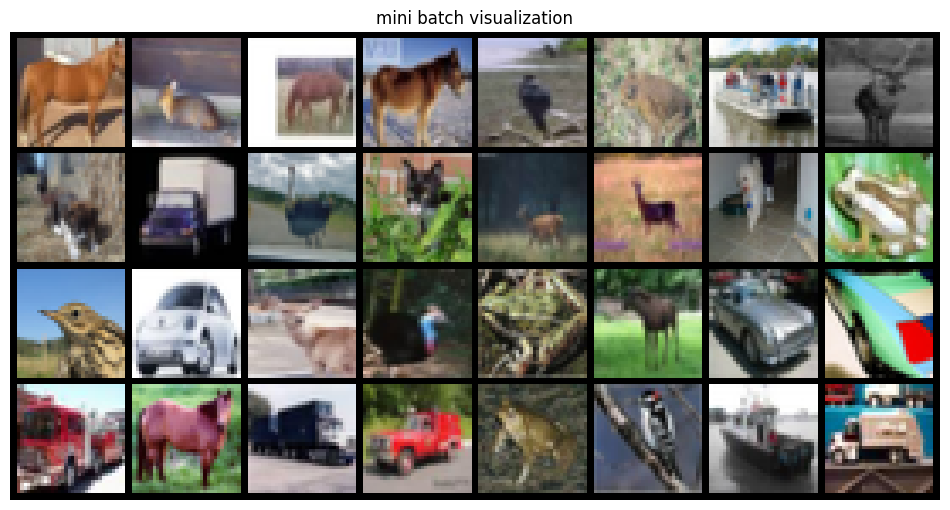

In [ ]:
grid = vutils.make_grid(images, nrow=8) # 각 행마다 8개의 이미지 배치하여 격자로 구성합니다.

# 학습 데이터로더로 부터 불러온 이미지를 시각화합니다
plt.figure(figsize=(12,12))
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.title("mini batch visualization")
plt.axis('off')
plt.show()

In [ ]:
in_channels = 3
num_classes = 10
for name in cfgs.keys():
    model_name = name
    model = VGG(model_name = model_name, cfgs = cfgs, in_channels = in_channels, num_classes = num_classes)
    print(f'{name} model parameters : ', model.count_parameters())

VGG11 model parameters :  28149514
VGG13 model parameters :  28334410
VGG16 model parameters :  33646666
VGG19 model parameters :  38958922


In [ ]:
# training 코드, evaluation 코드, training_loop 코드
def training(model, dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs):
  model.train()  # 모델을 학습 모드로 설정
  train_loss = 0.0
  train_accuracy = 0

  for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)

      # 순전파
      outputs = model(images)
      loss = criterion(outputs, labels)

      # 역전파 및 가중치 업데이트
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 손실과 정확도 계산
      train_loss += loss.item()
      # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
      _, predicted = torch.max(outputs, 1)
      train_accuracy += (predicted == labels).sum().item()


  # 에폭별 학습 결과 출력
  train_loss = train_loss / len(dataloader)
  train_accuracy = train_accuracy / len(train_dataset)

  return model, train_loss, train_accuracy

def evaluation(model, dataloader, val_dataset, criterion, device, epoch, num_epochs):
  model.eval()  # 모델을 평가 모드로 설정
  valid_loss = 0.0
  valid_accuracy = 0

  with torch.no_grad(): # model의 업데이트 막기
      for images, labels in dataloader:
          images = images.to(device)
          labels = labels.to(device)

          # 순전파
          outputs = model(images)
          loss = criterion(outputs, labels)

          # 손실과 정확도 계산
          valid_loss += loss.item()
          # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
          _, predicted = torch.max(outputs, 1)
          valid_accuracy += (predicted == labels).sum().item()


  valid_loss = valid_loss / len(dataloader)
  valid_accuracy = valid_accuracy / len(val_dataset)

  return model, valid_loss, valid_accuracy


def training_loop(model, train_dataloader, valid_dataloader, train_dataset, val_dataset, criterion, optimizer, device, num_epochs, patience, model_name):
    best_valid_loss = float('inf')  # 가장 좋은 validation loss를 저장
    early_stop_counter = 0  # 카운터
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, val_dataset, criterion, device, epoch, num_epochs)

        if valid_accuracy > valid_max_accuracy:
          valid_max_accuracy = valid_accuracy

        # validation loss가 감소하면 모델 저장 및 카운터 리셋
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"./model_{model_name}.pt")
            early_stop_counter = 0

        # validation loss가 증가하거나 같으면 카운터 증가
        else:
            early_stop_counter += 1


        # 조기 종료 카운터가 설정한 patience를 초과하면 학습 종료
        if early_stop_counter >= patience:
            print(f"Epoch [{epoch + 1}/{num_epochs}]")
            break

    return model, valid_max_accuracy

In [ ]:
def test(model, model_name, test_dataloader, device):
    model.load_state_dict(torch.load(f"./model_{model_name}.pt")) # 모델 불러오기
    model = model.to(device)
    model.eval()
    total_labels = []
    total_preds = []
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels

            outputs = model(images)
            # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
            _, predicted = torch.max(outputs.data, 1)

            total_preds.extend(predicted.detach().cpu().tolist())
            total_labels.extend(labels.tolist())

    total_preds = np.array(total_preds)
    total_labels = np.array(total_labels)
    acc = accuracy_score(total_labels, total_preds) # 정확도 계산
    print(f"{model_name} accuracy : ", acc)

In [ ]:
num_epochs = 100
in_channels = 3
num_classes = 10
lr = 1e-3
for name in cfgs.keys():
    model_name = name
    model = VGG(model_name = model_name, cfgs = cfgs, in_channels = in_channels, num_classes = num_classes).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, device, num_epochs, patience, model_name)
    print(f'{model_name} valid max accuracy : ', valid_max_accuracy)
    test(model, model_name, test_dataloader, device)
    print('---'*20)
    print()

Epoch [13/100]
VGG11 valid max accuracy :  0.7946
VGG11 accuracy :  0.7861
------------------------------------------------------------

Epoch [12/100]
VGG13 valid max accuracy :  0.819
VGG13 accuracy :  0.8185
------------------------------------------------------------

Epoch [14/100]
VGG16 valid max accuracy :  0.8297
VGG16 accuracy :  0.8177
------------------------------------------------------------

Epoch [20/100]
VGG19 valid max accuracy :  0.8123
VGG19 accuracy :  0.8169
------------------------------------------------------------



## 3. GoogLeNet 모델 구현하기

```
💡 목차 개요: GoogLeNet 모델을 직접 구현하고 CIFAR10 데이터셋으로 학습과 평가하는 과정을 실습합니다.
```

- 3-1. GoogLeNet 모델 구현하기
- 3-2. 학습과 평가하기

### 3-1 GoogLeNet 모델 구축하기

> GoogLeNet을 직접 구현해보고, GoogLeNet의 주 핵심인 inception module를 직접 구현해봅니다.


#### 📝 설명: GoogLeNet 모델이란?
<img src='https://cdn-images-1.medium.com/max/2560/1*ZFPOSAted10TPd3hBQU8iQ.png'></img>
* Inception이라고 불리우는 GoogLeNet은 VGGNet이 2등을 하였던 ImageNet 인식 대회에서 1등을 한 모델입니다.
* GoogLeNet의 핵심은 inception module 입니다.

<!-- - GoogLeNet convolution layer의 구조는 다음의 표와 같습니다.
<img src='https://cdn-images-1.medium.com/max/1600/1*CWJGqfLiVjHAIan82nPbjg.png'></img> -->


📚 참고할만한 자료:
* <a href='https://arxiv.org/abs/1409.4842'>GoogLeNet 논문</a>
* <a href='https://velog.io/@woojinn8/CNN-Networks-3.-GoogLeNet'>GoogLeNet 설명</a>
* <a href='https://arxiv.org/pdf/1409.4842.pdf'>그림 원본 출처 (GoogleNet)</a>

#### 📝 설명: Inception module이란?
<img src='https://gaussian37.github.io/assets/img/dl/concept/inception/5.png'></img>
* Inception 모듈은 convolution layer를 병렬적으로 사용하여 **다양한 필터의 크기에서 효율적으로 feature를 뽑아내는 것**을 목적으로 합니다.
* 여기서 1x1 convolution layer를 통해 차원을 줄여주어 효율적인 계산을 하게 합니다.
  * 1x1 convolution의 장점
    * 채널 수를 조절하여 계산량을 감소시킬 수 있다.
    * 활성화 함수와 같이 사용되면서 비선형성을 강조시킬 수 있다.

📚 참고할만한 자료:
* <a href='https://gaussian37.github.io/dl-concept-inception/'>Inception 모듈 설명</a>
* <a href='https://arxiv.org/pdf/1409.4842.pdf'>그림 원본 출처 (GoogleNet)</a>

In [ ]:
# https://github.com/soapisnotfat/pytorch-cifar10/blob/master/models/GoogleNet.py

class Inception(nn.Module):
    def __init__(self, in_channels, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_channels):
        super(Inception, self).__init__()
        # 1x1 conv
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, kernel_1_x, kernel_size=1), # 1x1 conv
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, kernel_3_in, kernel_size=1), # 1x1 conv
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(inplace = True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1), # 3x3 conv
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(inplace = True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, kernel_5_in, kernel_size=1), # 1x1 conv
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=5, padding=2), # 5x5 conv
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1), # 3x3 max pooling
            nn.Conv2d(in_channels, pool_channels, kernel_size=1), # 1x1 conv
            nn.BatchNorm2d(pool_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        '''
        INPUT :
            x = [batch_size, channel, height, width]
        OUTPUT :
            output = [batch_size, num_classes]
        '''
        y1 = self.branch1(x) # [batch_size, kernel_1_x, height, width]
        y2 = self.branch2(x) # [batch_size, kernel_3_x, height, width]
        y3 = self.branch3(x) # [batch_size, kernel_5_x, height, width]
        y4 = self.branch4(x) # [batch_size, pool_channels, height, width]
        # 병렬로 계산된 convolution 들을 모두 합쳐줍니다.
        return torch.cat([y1,y2,y3,y4], 1)  # [batch_size, kernel_1_x + kerenl_3_x + kernel_5_x + pool_channels, height, width]


class GoogLeNet(nn.Module): # googlenet 논문의 구조를 그대로 반영하였습니다.
    def __init__(self, num_classes, aux_logits = True):
        super(GoogLeNet, self).__init__()

        self.num_classes = num_classes
        self.aux_logits = aux_logits

        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.inception_1 = Inception(192,  64,  96, 128, 16, 32, 32) # inception 1, inception 2 이런 식으로 변수 이름 변경
        self.inception_2 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.inception_3 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.inception_4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.inception_5 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.inception_6 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.inception_7 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.inception_8 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception_9 = Inception(832, 384, 192, 384, 48, 128, 128)


        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, self.num_classes)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, x):
        '''
        INPUT :
            x = [batch_size, channel, height, width]
        OUTPUT :
            output = [batch_size, num_classes]
        '''
        x = self.pre_layers(x) # [batch_size, 192, height, width]
        x = self.inception_1(x) # [batch_size, 256, height, width]
        x = self.inception_2(x) # [batch_size, 480, height, width]
        x = self.max_pool(x) # [batch_size, 480, height//2, width//2]
        x = self.inception_3(x) # [batch_size, 512, height//2, width//2]
        x = self.inception_4(x) # [batch_size, 512, height//2, width//2]
        x = self.inception_5(x) # [batch_size, 512, height//2, width//2]
        x = self.inception_6(x) # [batch_size, 528, height//2, width//2]
        x = self.inception_7(x) # [batch_size, 832, height//2, width//2]
        x = self.max_pool(x) # [batch_size, 832, height//4, width//4]
        x = self.inception_8(x) # [batch_size, 832, height//4, width//4]
        x = self.inception_9(x) # [batch_size, 832, height//4, width//4]
        x = self.avgpool(x) # [batch_size, 1024, height//4, width//4]
        x = x.view(x.size(0), -1) # [batch_size, 1024, 1, 1]
        x = self.linear(x) # [batch_size, num_classes]
        x = self.softmax(x) # [batch_size, num_classes]
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
num_classes = 10
model = GoogLeNet(num_classes)
print("GoogleNet total paramters: ", model.count_parameters())

GoogleNet total paramters:  5879066


### 3-2 학습과 평가하기

> CIFAR10 데이터셋을 GoogLeNet으로 학습시켜 평가해봅니다.


#### 📝 설명: GoogLeNet 모델의 학습 및 평가
* GoogLeNet 모델을 학습을 시켜보고 CIFAR10에서의 분류 성능을 비교해봅니다.
* GoogLeNet 모델도 VGG와 동일하게 3채널을 가지는 ImageNet에서의 성능을 높이고자 하는 방법이기 때문에 동일하게 3채널을 가지는 CIFAR10 으로 실습해봅니다.
<!-- * 50개의 깊은 layer로 이루어져 있기 때문에, 32 x 32 사이즈를 가진 Cifar10 이미지를 그래도 ResNet에 넣으면 convolution 연산을 통과한 아웃풋 사이즈가 너무 작아지므로 오류가 발생합니다. 따라서, ImageNet 이미지 사이즈와 동일한 224 x 224 사이즈로 크기를 늘려주도록 합니다. -->

In [ ]:
# training 코드, evaluation 코드, training_loop 코드
def training(model, dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파
        outputs = model(images)

        loss = criterion(outputs, labels)

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 손실과 정확도 계산
        train_loss += loss.item()
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        # tqdm의 진행바에 표시될 설명 텍스트를 설정
        tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}")

  # 에폭별 학습 결과 출력
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, dataloader, val_dataset, criterion, device, epoch, num_epochs):
    model.eval()  # 모델을 평가 모드로 설정
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad(): # model의 업데이트 막기
        tbar = tqdm(dataloader)
        for images, labels in tbar:
            images = images.to(device)
            labels = labels.to(device)

            # 순전파
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 손실과 정확도 계산
            valid_loss += loss.item()
            # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
            _, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            # tqdm의 진행바에 표시될 설명 텍스트를 설정
            tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}")

    valid_loss = valid_loss / len(dataloader)
    valid_accuracy = valid_accuracy / len(val_dataset)

    return model, valid_loss, valid_accuracy


def training_loop(model, train_dataloader, valid_dataloader, train_dataset, val_dataset, criterion, optimizer, device, num_epochs, patience, model_name):
    best_valid_loss = float('inf')  # 가장 좋은 validation loss를 저장
    early_stop_counter = 0  # 카운터
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, val_dataset, criterion, device, epoch, num_epochs)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        # validation loss가 감소하면 모델 저장 및 카운터 리셋
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"./model_{model_name}.pt")
            early_stop_counter = 0

        # validation loss가 증가하거나 같으면 카운터 증가
        else:
            early_stop_counter += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        # 조기 종료 카운터가 설정한 patience를 초과하면 학습 종료
        if early_stop_counter >= patience:
            print("Early stopping")
            break

    return model, valid_max_accuracy

In [ ]:
model.to(device)
num_epochs = 100
patience = 3
model_name = 'GoogLeNet'

lr = 1e-3
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, device, num_epochs, patience, model_name)
print("GoogLeNet valid max accuracy: ", valid_max_accuracy)

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 1.3578, Train Accuracy: 0.5012 Valid Loss: 1.0392, Valid Accuracy: 0.6302


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.8733, Train Accuracy: 0.6934 Valid Loss: 0.7656, Valid Accuracy: 0.7360


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.6679, Train Accuracy: 0.7674 Valid Loss: 0.7851, Valid Accuracy: 0.7340


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.5526, Train Accuracy: 0.8107 Valid Loss: 0.5533, Valid Accuracy: 0.8094


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.4667, Train Accuracy: 0.8398 Valid Loss: 0.5331, Valid Accuracy: 0.8185


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.3949, Train Accuracy: 0.8599 Valid Loss: 0.5104, Valid Accuracy: 0.8254


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.3271, Train Accuracy: 0.8867 Valid Loss: 0.5139, Valid Accuracy: 0.8239


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.2773, Train Accuracy: 0.9039 Valid Loss: 0.5095, Valid Accuracy: 0.8359


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.2318, Train Accuracy: 0.9191 Valid Loss: 0.4978, Valid Accuracy: 0.8414


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.1954, Train Accuracy: 0.9321 Valid Loss: 0.5101, Valid Accuracy: 0.8445


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.1636, Train Accuracy: 0.9422 Valid Loss: 0.5487, Valid Accuracy: 0.8409


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.1438, Train Accuracy: 0.9499 Valid Loss: 0.5367, Valid Accuracy: 0.8490
Early stopping
GoogLeNet valid max accuracy:  0.849


In [ ]:
test(model, model_name, test_dataloader, device)

GoogLeNet accuracy :  0.8413


## 4. ResNet 모델 구현하기

```
💡 목차 개요: ResNet 모델을 직접 구현하고 CIFAR10 데이터셋으로 학습과 평가하는 과정을 실습합니다.
```

- 4-1. ResNet 모델 구현하기
- 4-2. 학습과 평가하기

### 4-1 ResNet 모델 구현하기

> ResNet50을 직접 구현해보고, ResNet의 주 핵심인 BottleNeck Layer를 직접 구현해봅니다.


#### 📝 설명: ResNet 모델이란?
<img src='https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/resnet_architecture.png'></img>
* ResNet은 convolution layer를 많이 쌓았을 때, train의 성능과 test의 성능 모두 하락하는 degradation 문제가 발생하는 것을 해결하기 위해 제안한 논문입니다.
* convolution layer를 통과하지 않은 값과 convolution layer를 통과한 값을 더해주는 residual learning (skip connection)방식으로 convolution layer를 성능 손실 방지할 수 있게 되었습니다.


📚 참고할만한 자료:
* <a href='https://arxiv.org/abs/1512.03385'>ResNet 논문</a>
* <a href='https://wjunsea.tistory.com/99'>ResNet 설명</a>
* <a href='https://arxiv.org/abs/1512.03385'>ResNet 그림 출처</a>

#### 📝 설명: Bottleneck building block
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fv9dfl%2Fbtq0ECY6ZxN%2FsFgJJrK7FrUoNNuhASnqG1%2Fimg.png'></img>
* Bottleneck layer는 1x1 convolution 연산을 이용하여 채널의 수와 연산량을 감소시키고, skip connection을 수행합니다.


📚 참고할만한 자료:
* <a href='https://velog.io/@lighthouse97/CNN%EC%9D%98-Bottleneck%EC%97%90-%EB%8C%80%ED%95%9C-%EC%9D%B4%ED%95%B4'>BottleNeck building block 설명</a>
* <a href='https://arxiv.org/abs/1512.03385'>그림 원 출처(ResNet)</a>

In [ ]:
# https://github.com/CryptoSalamander/pytorch_paper_implementation/blob/master/resnet/resnet.py
class BottleNeck(nn.Module): # bottleneck buliding block
    def __init__(self, in_channels, out_channels, stride=1, mul=4):
        super(BottleNeck, self).__init__()
        self.mul = mul # 출력 채널 수를 몇 배로 늘릴 것인지
        #첫 Convolution은 너비와 높이 downsampling
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False) # 1 x 1 conv
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) # 3 x 3 conv
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.mul, kernel_size=1, stride=1, bias=False) # 1 x 1 conv
        self.bn3 = nn.BatchNorm2d(out_channels*self.mul)


        self.shortcut = nn.Sequential() # input 값이 그대로 반환됩니다.

        # shortcut connection: 입력 x의 크기를 맞추기 위해 1x1 컨볼루션 및 배치 정규화 수행
        # stride 같은 요소 때문에 출력의 크기가 달라질 수 있습니다.
        if stride != 1 or in_channels != out_channels*self.mul:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*self.mul, kernel_size=1, stride=stride, bias=False), # 1 x 1 conv
                nn.BatchNorm2d(out_channels*self.mul)
            )

    def forward(self, x):
        out = self.conv1(x) # [batch_size, out_channels, height, width]
        out = self.bn1(out) # [batch_size, out_channels, height, width]
        out = F.relu(out) # [batch_size, out_channels, height, width]
        out = self.conv2(out) # [batch_size, out_channels, height, width]
        out = self.bn2(out) # [batch_size, out_channels, height, width]
        out = F.relu(out) # [batch_size, out_channels, height, width]
        out = self.conv3(out) # [batch_size, out_channels*mul, height, width]
        out = self.bn3(out) # [batch_size, out_channels*mul, height, width]
        # skip connection
        out += self.shortcut(x) # [batch_size, out_channels*mul, height, width] or [batch_size, out_channels*mul*mul, height, width]
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block_mul, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        #RGB 3개채널에서 64개의 Kernel 사용
        self.in_channels = 64

        # Resnet 논문 구조 그대로 구현
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding = 3)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block_mul, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block_mul, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block_mul, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block_mul, 512, num_blocks[3], stride=2)
        # Global Average Pooling 레이어 => 1차원 벡터로 만들기 위함
        # Global average pooling 참고자료: https://gaussian37.github.io/dl-concept-global_average_pooling/
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block_mul, num_classes)
        self.softmax = nn.LogSoftmax(dim = 1)

    def make_layer(self, block_mul, out_channels, num_blocks, stride):
        # layer 앞부분에서만 크기를 절반으로 줄이므로, 아래와 같은 구조
        '''
        ex) stride = 2이고 num_blocks = 3인 경우, strides는 [2, 1, 1]로 생성되며,
        Bottleneck 블록들이 stride=2로 시작하여 앞부분에서 크기를 절반으로 줄이고, 나머지 블록들은 크기를 그대로 유지
        '''
        strides = [stride] + [1] * (num_blocks-1) # BottleNeck block의 stride 리스트 설정
        layers = []
        for i in range(num_blocks):
            layers.append(BottleNeck(self.in_channels, out_channels, strides[i], block_mul))
            self.in_channels = block_mul * out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        '''
        INPUT :
            x = [batch_size, channel, height, width]
        OUTPUT :
            output = [batch_size, num_classes]
        '''
        out = self.conv1(x) # [batch_size, 64, height//2, width//2]
        out = self.bn1(out) # [batch_size, 64, height//2, width//2]
        out = F.relu(out) # [batch_size, 64, height//2, width//2]
        out = self.maxpool1(out) # [batch_size, 64, height//4, width//4]
        out = self.layer1(out) # [batch_size, 256, height//4, width//4]
        out = self.layer2(out) # [batch_size, 512, height//8, width//8]
        out = self.layer3(out) # [batch_size, 1024, height//16, width//16]
        out = self.layer4(out) # [batch_size, 2048, height//32, width//32]
        out = self.avgpool(out) # [batch_size, 2048, height//32, width//32]
        out = torch.flatten(out, 1) # [batch_size, 2048, 1, 1]
        out = self.linear(out) # [batch_size, 2048]
        out = self.softmax(out) # [batch_size, num_classes]
        return out

    def count_parameters(self):
            return sum(p.numel() for p in self.parameters() if p.requires_grad)

def ResNet50():
    return ResNet(4, [3, 4, 6, 3])

In [ ]:
model = ResNet50().to(device)
print("ResNet50 total parameters: ", model.count_parameters())

ResNet50 total parameters:  23528586


### 4-2 학습과 평가하기

> CIFAR10 데이터셋으로 ResNet50을 학습시켜 평가해봅니다.


#### 📝 설명: ResNet 모델의 학습 및 평가
* ResNet 모델을 학습을 시켜보고 CIFAR10에서의 분류 성능을 비교해봅니다.
* ResNet모델도 VGG와 동일하게 3채널을 가지는 ImageNet에서의 성능을 높이고자 하는 방법이기 때문에 동일하게 3채널을 가지는 CIFAR10 으로 실습해봅니다.
<!-- * 50개의 깊은 layer로 이루어져 있기 때문에, 32 x 32 사이즈를 가진 Cifar10 이미지를 그래도 ResNet에 넣으면 convolution 연산을 통과한 아웃풋 사이즈가 너무 작아지므로 오류가 발생합니다. 따라서, ImageNet 이미지 사이즈와 동일한 224 x 224 사이즈로 크기를 늘려주도록 합니다. -->

In [ ]:
# 하이퍼 파라미터 튜닝 좀 해서 성능 올리기 (patience 좀 높게)

In [ ]:
model_name = 'ResNet50'
num_epochs = 100
patience = 3

lr = 1e-3
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, device, num_epochs, patience, model_name)
print("Valid max accuracy: ", valid_max_accuracy)

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 2.0561, Train Accuracy: 0.3228 Valid Loss: 2.4199, Valid Accuracy: 0.3008


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 1.7325, Train Accuracy: 0.4265 Valid Loss: 2.4024, Valid Accuracy: 0.4387


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 1.7143, Train Accuracy: 0.4211 Valid Loss: 2.3619, Valid Accuracy: 0.3248


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 1.6606, Train Accuracy: 0.4223 Valid Loss: 1.5820, Valid Accuracy: 0.4921


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 1.6204, Train Accuracy: 0.4533 Valid Loss: 1.5176, Valid Accuracy: 0.4678


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 1.4077, Train Accuracy: 0.5114 Valid Loss: 1.2575, Valid Accuracy: 0.5553


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 1.3377, Train Accuracy: 0.5350 Valid Loss: 1.3124, Valid Accuracy: 0.5289


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 1.3504, Train Accuracy: 0.5326 Valid Loss: 1.5534, Valid Accuracy: 0.5850


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 1.1584, Train Accuracy: 0.5959 Valid Loss: 1.0593, Valid Accuracy: 0.6241


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 1.0191, Train Accuracy: 0.6445 Valid Loss: 1.3268, Valid Accuracy: 0.5297


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 1.0366, Train Accuracy: 0.6397 Valid Loss: 1.1518, Valid Accuracy: 0.6271


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.8974, Train Accuracy: 0.6874 Valid Loss: 0.9243, Valid Accuracy: 0.6690


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.8599, Train Accuracy: 0.7033 Valid Loss: 1.0445, Valid Accuracy: 0.6661


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.7487, Train Accuracy: 0.7409 Valid Loss: 0.8800, Valid Accuracy: 0.6989


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.6975, Train Accuracy: 0.7606 Valid Loss: 0.8542, Valid Accuracy: 0.7059


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.6344, Train Accuracy: 0.7808 Valid Loss: 0.8565, Valid Accuracy: 0.7079


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.5601, Train Accuracy: 0.8074 Valid Loss: 1.0000, Valid Accuracy: 0.6775


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.4955, Train Accuracy: 0.8285 Valid Loss: 0.8466, Valid Accuracy: 0.7158


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.4420, Train Accuracy: 0.8459 Valid Loss: 0.9000, Valid Accuracy: 0.7199


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.5002, Train Accuracy: 0.8294 Valid Loss: 0.9402, Valid Accuracy: 0.7124


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.3177, Train Accuracy: 0.8897 Valid Loss: 0.9340, Valid Accuracy: 0.7332
Early stopping
Valid max accuracy:  0.7332


In [ ]:
test(model, model_name, test_dataloader, device)

ResNet50 accuracy :  0.7153


## Reference
* [GoogleNet](https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/Classification/GoogLeNet(2014).ipynb)
* [ResNet](https://github.com/CryptoSalamander/pytorch_paper_implementation/blob/master/resnet/resnet.py)



## Required Package

> torch == 2.0.1

> torchvision == 0.15.2

> sklearn == 1.3.0

## 콘텐츠 라이선스

저작권 : <font color='blue'> <b> ©2023 by Upstage X fastcampus Co., Ltd. All rights reserved.</font></b>

<font color='red'><b>WARNING</font> : 본 교육 콘텐츠의 지식재산권은 업스테이지 및 패스트캠퍼스에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다. </b>